### **Import Library:** 분석에 사용할 모듈 설치

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# for regression
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error

### **Data Loading:** 분석에 사용할 데이터 불러오기

In [2]:
# 보스턴 집값 데이터 로딩
df = pd.read_csv('./data/Price.csv')
display(df)

,Price,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.00,0.01,'18',2.31,'0',0.54,6.58,65.20,4.09,1,296,15.30,396.90,4.98
1,21.60,0.03,'0',7.07,'0',0.47,6.42,78.90,4.97,2,242,17.80,396.90,9.14
2,34.70,0.03,'0',7.07,'0',0.47,7.18,61.10,4.97,2,242,17.80,392.83,4.03
3,33.40,0.03,'0',2.18,'0',0.46,7.00,45.80,6.06,3,222,18.70,394.63,2.94
4,36.20,0.07,'0',2.18,'0',0.46,7.15,54.20,6.06,3,222,18.70,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,22.40,0.06,'0',11.93,'0',0.57,6.59,69.10,2.48,1,273,21.00,391.99,9.67
502,20.60,0.05,'0',11.93,'0',0.57,6.12,76.70,2.29,1,273,21.00,396.90,9.08
503,23.90,0.06,'0',11.93,'0',0.57,6.98,91.00,2.17,1,273,21.00,396.90,5.64
504,22.00,0.11,'0',11.93,'0',0.57,6.79,89.30,2.39,1,273,21.00,393.45,6.48


|   **변수**  |              **설명**              |
|:-------:|:------------------------------:|
|  **Price**  |            주택 가격           |
|   **CRIM**  |        1인당 범죄 발생률       |
|    **ZN**   |       주택용 토지의 비율       |
|  **INDUS**  |      비소매 상업지역 비율      |
|   **CHAS**  |    찰스강 인접 여부(인접=1)    |
|   **NOX**   |         일산화질소 농도        |
|    **RM**   |            방의 개수           |
|   **AGE**   | 1940년 이전에 건축된 주택 비율 |
|   **DIS**   |     주요 5대 회사와의 거리     |
|   **RAD**   |         고속도로 접근성        |
|   **TAX**   |             재산세             |
| **PTRATIO** |       교사와 학생의 비율       |
|    **B**    |         흑인 거주 비율         |
|  **LSTAT**  |          저소득층 비율         |

### **Preprocessing:** 데이터 정리 및 패턴 추출하기

In [ ]:
# 자료형 변환 + 결측값 처리
def prep(df_origin):
    df = df_origin.copy()

    # 자료형 변환
    # 각 column의 타입이 문자인 경우 숫자로 변환하기
    col = []
    if df['ZN'].dtype == 'object':
        for i in df['ZN']:
            col.append(float(i[1:-1]))
        df['ZN'] = col

    col = []
    if df['CHAS'].dtype == 'object':
        for i in df['CHAS']:
            col.append(float(i[1:-1]))
        df['CHAS'] = col
    
    # 결측값 처리
    # 정규분포와 유사한 변수는 평균으로 채우되, 그렇지 않은 변수는 중앙값으로 채움
    for i in df.columns[df.isnull().sum() != 0]:
        if i not in ['INDUS', 'RM']:
            df[i].fillna(df[i].mean(), inplace=True)
        else:
            df[i].fillna(df[i].median(), inplace=True)
            
    return df


# 데이터 분리
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    # 종속변수와 독립변수 분리하기
    X_colname = [x for x in df.columns if x not in Y_colname]

    # train_test_split 함수를 사용하여 X_train, X_test, Y_train, Y_test 4개의 집단으로 구분하기
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


# 데이터 변환
def feature_engineering(df_origin):
    df = df_origin.copy()
    
    # 범주형 변환을 위한 기준점들 정하기
    # 범주형 값으로 변환하여 기존 값 대체하기
    interval = [100, 200, 300, 400, 500, 600, 700, 800]
    if df['TAX'].max() >= 100:
        df['TAX'] = np.digitize(df['TAX'], bins=interval)
        
    # 범주형 TAX를 가변수로 변경하고 기존 TAX 삭제하기
    if 'TAX' in df.columns:
        df_dummy = pd.get_dummies(df['TAX'], prefix='TAX', drop_first=True)
        df = pd.concat([df, df_dummy], axis=1)
        del df['TAX']
        
    # 범주형 CHAS를 가변수로 변경하고 기존 CHAS 삭제하기
    if 'CHAS' in df.columns:
        df['CHAS'] = df['CHAS'].astype(int)
        df_dummy = pd.get_dummies(df['CHAS'], prefix='CHAS', drop_first=False)
        df = pd.concat([df, df_dummy], axis=1)
        del df['CHAS']
    
    return df


# 데이터 변환 후 X_train과 X_test의 변수 갯수 일치
def col_mapping(X_train, X_test):
    X_tr = X_train.copy()
    X_te = X_test.copy()

    # Train & Test 변수명 체크
    X_te_noncol = [i for i in X_tr.columns if i not in X_te.columns]
    X_tr_noncol = [i for i in X_te.columns if i not in X_tr.columns]

    # 변수 갯수 일치
    if X_te_noncol != []:
        for i in X_te_noncol:
            X_te[i] = 0
        X_te = X_te[X_tr.columns].copy()
    
    if X_tr_noncol != []:
        for i in X_tr_noncol:
            X_tr[i] = 0
        X_tr = X_tr[X_te.columns].copy()
    
    return X_tr, X_te


# 스케일 조정
def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                                   index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                                  index=X_test.index, columns=X_test.columns)
    
    return X_train_scaling, X_test_scaling

In [4]:
# 데이터 전처리
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

(404, 13) (404, 1)
(102, 13) (102, 1)


In [5]:
# 원데이터 확인
display(X_train, X_test, Y_train, Y_test)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
203,0.04,95.00,2.68,0.00,0.42,7.85,33.20,5.12,4,224,14.70,392.78,12.97
441,9.72,0.00,18.10,0.00,0.74,6.41,97.20,2.07,24,666,20.20,385.96,19.52
172,0.14,0.00,4.05,0.00,0.51,5.57,88.50,2.60,5,296,16.60,396.90,14.69
95,0.12,0.00,2.89,0.00,0.45,6.62,57.80,3.82,2,276,18.00,357.98,6.65
54,0.01,75.00,4.00,0.00,0.41,5.89,47.60,7.32,3,469,21.10,396.90,14.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.08,0.00,2.89,0.00,0.45,7.82,36.90,3.82,2,276,18.00,393.53,12.97
476,4.87,0.00,18.10,0.00,0.61,6.48,93.60,2.31,24,666,20.20,396.21,18.68
322,0.35,0.00,7.38,0.00,0.49,6.04,49.90,4.72,5,287,19.60,396.90,7.70
382,9.19,0.00,18.10,0.00,0.70,5.54,100.00,1.58,24,666,20.20,396.90,23.60


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
410,51.14,0.00,18.10,0.00,0.60,5.76,100.00,1.41,24,666,20.20,2.60,10.11
85,0.06,0.00,4.49,0.00,0.45,6.63,56.10,4.44,3,247,18.50,392.30,6.53
280,0.04,20.00,9.90,0.00,0.44,7.82,64.50,4.69,5,216,14.90,387.31,12.97
422,12.05,0.00,18.10,0.00,0.61,5.65,87.60,1.95,24,666,20.20,291.55,14.10
199,0.03,95.00,1.47,0.00,0.40,6.97,15.30,7.65,3,402,17.00,396.90,4.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.44,0.00,6.20,0.00,0.50,6.55,21.40,3.82,8,307,17.40,380.34,12.97
159,1.43,0.00,19.58,0.00,0.87,6.51,100.00,1.77,5,403,14.70,364.31,7.39
196,0.04,80.00,1.52,0.00,0.40,7.29,34.10,7.31,2,329,12.60,396.90,4.08
345,0.03,0.00,4.39,0.00,0.44,6.01,48.50,8.01,3,352,18.80,385.64,10.53


,Price
203,48.50
441,17.10
172,23.10
95,28.40
54,18.90
...,...
98,43.80
476,16.70
322,20.40
382,11.30


,Price
410,15.00
85,26.60
280,45.40
422,20.80
199,34.90
...,...
229,31.50
159,23.30
196,33.30
345,17.50


In [6]:
# 전처리 출력
display(X_train_fe, X_test_fe, Y_train, Y_test)

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7,CHAS_0,CHAS_1
203,0.04,95.00,2.68,0.42,7.85,33.20,5.12,4,14.70,392.78,12.97,True,False,False,False,False,True,False
441,9.72,0.00,18.10,0.74,6.41,97.20,2.07,24,20.20,385.96,19.52,False,False,False,True,False,True,False
172,0.14,0.00,4.05,0.51,5.57,88.50,2.60,5,16.60,396.90,14.69,True,False,False,False,False,True,False
95,0.12,0.00,2.89,0.45,6.62,57.80,3.82,2,18.00,357.98,6.65,True,False,False,False,False,True,False
54,0.01,75.00,4.00,0.41,5.89,47.60,7.32,3,21.10,396.90,14.80,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.08,0.00,2.89,0.45,7.82,36.90,3.82,2,18.00,393.53,12.97,True,False,False,False,False,True,False
476,4.87,0.00,18.10,0.61,6.48,93.60,2.31,24,20.20,396.21,18.68,False,False,False,True,False,True,False
322,0.35,0.00,7.38,0.49,6.04,49.90,4.72,5,19.60,396.90,7.70,True,False,False,False,False,True,False
382,9.19,0.00,18.10,0.70,5.54,100.00,1.58,24,20.20,396.90,23.60,False,False,False,True,False,True,False


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7,CHAS_0,CHAS_1
410,51.14,0.00,18.10,0.60,5.76,100.00,1.41,24,20.20,2.60,10.11,False,False,False,True,0,True,False
85,0.06,0.00,4.49,0.45,6.63,56.10,4.44,3,18.50,392.30,6.53,True,False,False,False,0,True,False
280,0.04,20.00,9.90,0.44,7.82,64.50,4.69,5,14.90,387.31,12.97,True,False,False,False,0,True,False
422,12.05,0.00,18.10,0.61,5.65,87.60,1.95,24,20.20,291.55,14.10,False,False,False,True,0,True,False
199,0.03,95.00,1.47,0.40,6.97,15.30,7.65,3,17.00,396.90,4.56,False,False,True,False,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.44,0.00,6.20,0.50,6.55,21.40,3.82,8,17.40,380.34,12.97,False,True,False,False,0,True,False
159,1.43,0.00,19.58,0.87,6.51,100.00,1.77,5,14.70,364.31,7.39,False,False,True,False,0,True,False
196,0.04,80.00,1.52,0.40,7.29,34.10,7.31,2,12.60,396.90,4.08,False,True,False,False,0,True,False
345,0.03,0.00,4.39,0.44,6.01,48.50,8.01,3,18.80,385.64,10.53,False,True,False,False,0,True,False


,Price
203,48.50
441,17.10
172,23.10
95,28.40
54,18.90
...,...
98,43.80
476,16.70
322,20.40
382,11.30


,Price
410,15.00
85,26.60
280,45.40
422,20.80
199,34.90
...,...
229,31.50
159,23.30
196,33.30
345,17.50


In [7]:
# 전처리 스케일 조정 출력
display(X_train_fes, X_test_fes, Y_train, Y_test)

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7,CHAS_0,CHAS_1
203,0.00,0.95,0.08,0.06,0.81,0.29,0.36,0.13,0.22,0.99,0.32,1.00,0.00,0.00,0.00,0.00,1.00,0.00
441,0.11,0.00,0.65,0.73,0.49,0.97,0.08,1.00,0.81,0.97,0.50,0.00,0.00,0.00,1.00,0.00,1.00,0.00
172,0.00,0.00,0.13,0.26,0.31,0.88,0.13,0.17,0.43,1.00,0.37,1.00,0.00,0.00,0.00,0.00,1.00,0.00
95,0.00,0.00,0.09,0.12,0.54,0.55,0.24,0.04,0.57,0.90,0.14,1.00,0.00,0.00,0.00,0.00,1.00,0.00
54,0.00,0.75,0.13,0.05,0.38,0.44,0.56,0.09,0.90,1.00,0.37,0.00,0.00,1.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.00,0.00,0.09,0.12,0.80,0.33,0.24,0.04,0.57,0.99,0.32,1.00,0.00,0.00,0.00,0.00,1.00,0.00
476,0.05,0.00,0.65,0.47,0.51,0.93,0.10,1.00,0.81,1.00,0.48,0.00,0.00,0.00,1.00,0.00,1.00,0.00
322,0.00,0.00,0.25,0.22,0.41,0.47,0.32,0.17,0.74,1.00,0.17,1.00,0.00,0.00,0.00,0.00,1.00,0.00
382,0.10,0.00,0.65,0.65,0.30,1.00,0.04,1.00,0.81,1.00,0.62,0.00,0.00,0.00,1.00,0.00,1.00,0.00


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7,CHAS_0,CHAS_1
410,0.57,0.00,0.65,0.44,0.35,1.00,0.02,1.00,0.81,0.01,0.24,0.00,0.00,0.00,1.00,0.00,1.00,0.00
85,0.00,0.00,0.15,0.13,0.54,0.53,0.30,0.09,0.63,0.99,0.14,1.00,0.00,0.00,0.00,0.00,1.00,0.00
280,0.00,0.20,0.35,0.12,0.80,0.62,0.32,0.17,0.24,0.98,0.32,1.00,0.00,0.00,0.00,0.00,1.00,0.00
422,0.14,0.00,0.65,0.47,0.33,0.87,0.07,1.00,0.81,0.73,0.35,0.00,0.00,0.00,1.00,0.00,1.00,0.00
199,0.00,0.95,0.04,0.04,0.62,0.10,0.59,0.09,0.47,1.00,0.08,0.00,0.00,1.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.00,0.00,0.21,0.24,0.53,0.16,0.24,0.30,0.51,0.96,0.32,0.00,1.00,0.00,0.00,0.00,1.00,0.00
159,0.02,0.00,0.70,1.00,0.52,1.00,0.05,0.17,0.22,0.92,0.16,0.00,0.00,1.00,0.00,0.00,1.00,0.00
196,0.00,0.80,0.04,0.04,0.69,0.30,0.56,0.04,0.00,1.00,0.07,0.00,1.00,0.00,0.00,0.00,1.00,0.00
345,0.00,0.00,0.14,0.12,0.41,0.45,0.62,0.09,0.66,0.97,0.25,0.00,1.00,0.00,0.00,0.00,1.00,0.00


,Price
203,48.50
441,17.10
172,23.10
95,28.40
54,18.90
...,...
98,43.80
476,16.70
322,20.40
382,11.30


,Price
410,15.00
85,26.60
280,45.40
422,20.80
199,34.90
...,...
229,31.50
159,23.30
196,33.30
345,17.50


In [8]:
# 전처리 후 통계량 확인하기
display(X_train_fes.describe(), X_test_fes.describe(), Y_train.describe(), Y_test.describe())

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7,CHAS_0,CHAS_1
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,0.04,0.11,0.41,0.35,0.47,0.67,0.24,0.37,0.62,0.90,0.32,0.29,0.27,0.13,0.26,0.01,0.94,0.06
std,0.10,0.23,0.25,0.24,0.15,0.30,0.19,0.38,0.23,0.22,0.20,0.46,0.44,0.34,0.44,0.11,0.23,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.20,0.14,0.38,0.42,0.08,0.13,0.51,0.95,0.17,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,0.00,0.00,0.35,0.31,0.45,0.76,0.18,0.17,0.69,0.99,0.30,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,0.04,0.12,0.65,0.49,0.54,0.94,0.36,1.00,0.81,1.00,0.44,1.00,1.00,0.00,1.00,0.00,1.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT,TAX_2,TAX_3,TAX_4,TAX_6,TAX_7,CHAS_0,CHAS_1
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
mean,0.04,0.12,0.40,0.34,0.47,0.65,0.25,0.38,0.62,0.89,0.30,0.28,0.31,0.10,0.27,0.00,0.88,0.12
std,0.09,0.25,0.22,0.24,0.15,0.31,0.18,0.39,0.24,0.23,0.20,0.45,0.47,0.30,0.45,0.00,0.32,0.32
min,0.00,0.00,0.03,0.01,0.00,-0.03,-0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.24,0.13,0.38,0.40,0.09,0.13,0.48,0.92,0.14,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,0.00,0.00,0.35,0.31,0.46,0.74,0.24,0.17,0.69,0.98,0.28,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,0.04,0.12,0.65,0.49,0.55,0.93,0.38,1.00,0.81,1.00,0.41,1.00,1.00,0.00,1.00,0.00,1.00,0.00
max,0.57,0.95,0.92,1.00,1.01,1.00,0.69,1.00,0.91,1.00,1.03,1.00,1.00,1.00,1.00,0.00,1.00,1.00


,Price
count,404.00
mean,22.37
std,9.22
min,5.00
25%,17.08
50%,21.20
75%,24.80
max,50.00


,Price
count,102.00
mean,23.16
std,9.14
min,7.20
25%,16.83
50%,21.30
75%,26.90
max,50.00


### **Applying Base Algorithm:** Linear Regression

In [9]:
# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     68.67
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          2.71e-105
Time:                        21:34:39   Log-Likelihood:                -1188.7
No. Observations:                 404   AIC:                             2413.
Df Residuals:                     386   BIC:                             2486.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1290      2.030      8.439      0.000      13.138      21.120
CRIM          -9.7685      3.129     -3.122      0.002     -15.921      -3.616
ZN             3.6059      1.538      2.345      0.020       0.583       6.629
INDUS         -1.0711      1.956     -0.548      0.584      -4.917       2.774
NOX           -6.8870      2.163     -3.184      0.002     -11.140      -2.634
RM            28.7478      2.137     13.453      0.000      24.546      32.949
AGE           -3.1799      1.386     -2.294      0.022      -5.906      -0.454
DIS          -14.1170      2.480     -5.691      0.000     -18.994      -9.240
RAD           10.9837      4.247      2.586      0.010       2.633      19.334
PTRATIO       -8.1534      1.388     -5.874      0.000     -10.882      -5.424
B              4.1760      1.233      3.387      0.001       1.752       6.600
LSTAT        -10.0753      2.011     -5.010      0.000     -14.029      -6.122
TAX_2         -5.2255      1.405     -3.719      0.000      -7.988      -2.463
TAX_3         -5.7704      1.463     -3.945      0.000      -8.646      -2.894
TAX_4         -5.2109      1.538     -3.389      0.001      -8.234      -2.187
TAX_6        -13.2573      4.293     -3.088      0.002     -21.697      -4.817
TAX_7         -6.4422      2.668     -2.414      0.016     -11.688      -1.196
CHAS_0         7.7912      1.035      7.528      0.000       5.756       9.826
CHAS_1         9.3378      1.235      7.559      0.000       6.909      11.767
==============================================================================
Omnibus:                      241.516   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3120.749
Skew:                           2.289   Prob(JB):                         0.00
Kurtosis:                      15.823   Cond. No.                     1.09e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.58e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

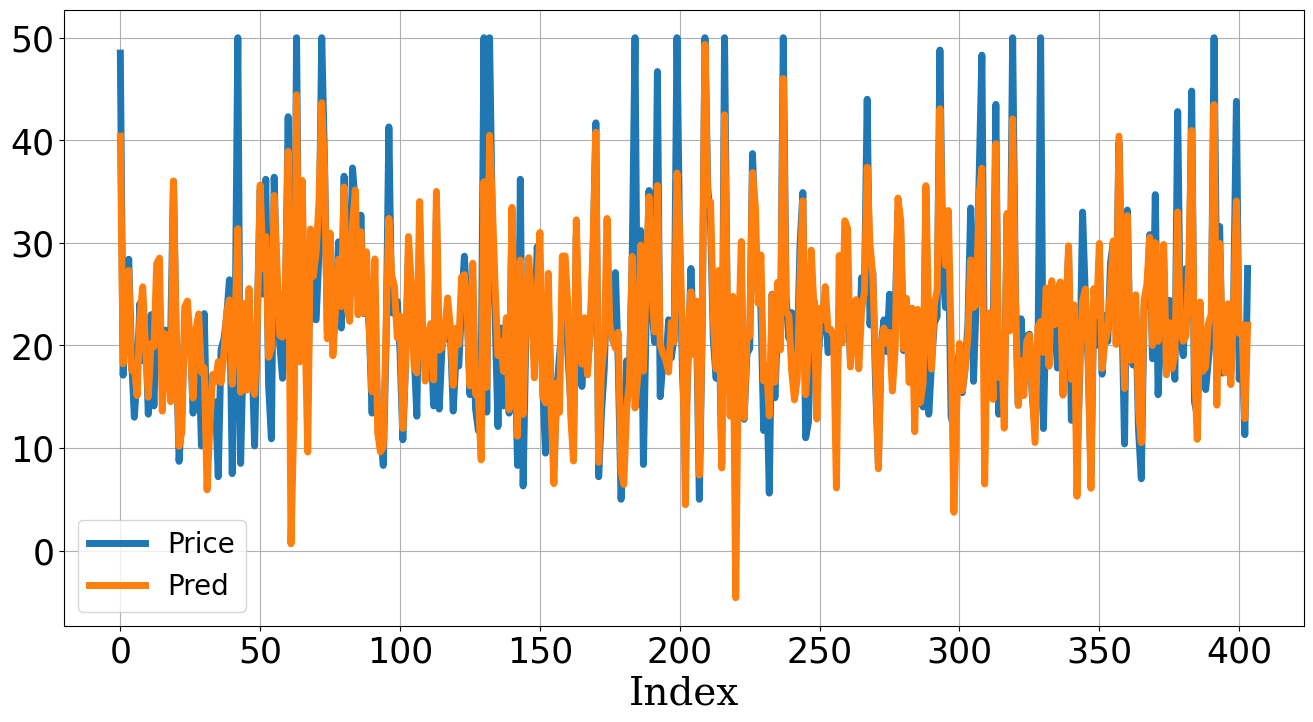

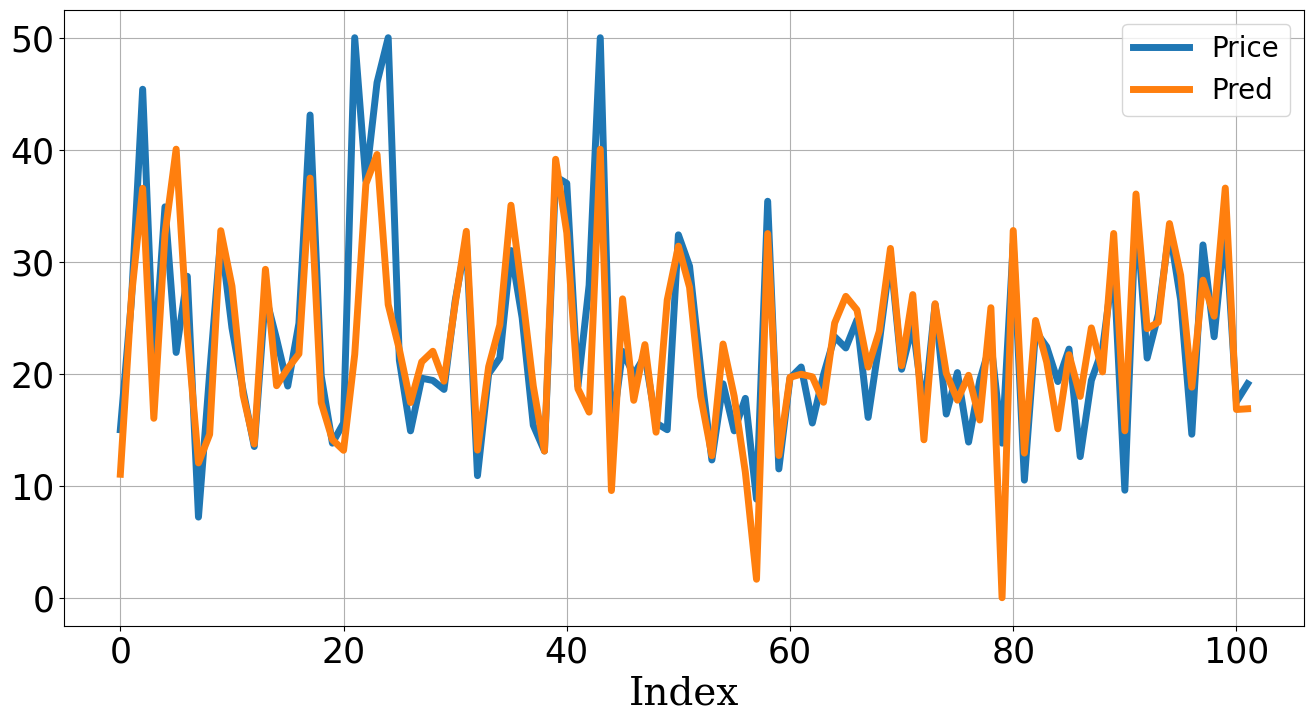

In [ ]:
# Linear Regression
# 데이터 전체의 왜곡을 줄이기 위해 Y절편 또는 상수항을 출력을 위한 상수 변수를 추가
X_train_fes = sm.add_constant(X_train_fes)
X_test_fes = sm.add_constant(X_test_fes)

# 회귀분석 실행하고 model 변수에 저장하기
model_lr = sm.OLS(Y_train, X_train_fes).fit()
display(model_lr.summary())

# 학습된 모델을 사용하여 X_train 및 X_test 값 예측하고 변수로 저장
Y_trpred = pd.DataFrame(model_lr.predict(X_train_fes), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr.predict(X_test_fes), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

### **Evaluation:** 분석 성능 확인/평가하기

In [ ]:
# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    # MSE, MAE, MAPE 정리
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    return Score

# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte

In [12]:
# 분석 검증
Score = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
Score

,MAE,MSE,MAPE
Train,3.07,21.05,0.16
Test,3.51,31.34,0.17


### **Error Analysis:** 분석 성능/종료 판단하기

In [13]:
# 에러 분석
def error_analysis(X_Data, Y_Pred, Residual, graph_on=False):
    if graph_on == True:
        # 시각화
        # 잔차의 정규본포성 확인
        sns.distplot(Residual, norm_hist='True', fit=stats.norm)
        plt.show()

        # 잔차의 등분산성 확인
        temp = pd.concat([Y_Pred, Residual.reset_index().iloc[:,[1]]], axis=1)
        sns.scatterplot(x='Pred', y='Error', data=temp)
        plt.show()
        
        # 잔차의 자기상관성 확인
        sm.graphics.tsa.plot_acf(Residual, lags=50, use_vlines=True)
        plt.show()

    # 통계량
    # 정규분포
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)], 
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # 등분산성
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], 
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T
    
    # 자기상관
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,0]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,1])], axis=1).T
    Autocorrelation.index = ['Test Statistics', 'p-value']
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']
    
    Error_Analysis = pd.concat([Normality, Heteroscedasticity, Autocorrelation], join='outer', axis=1)
    
    return Error_Analysis

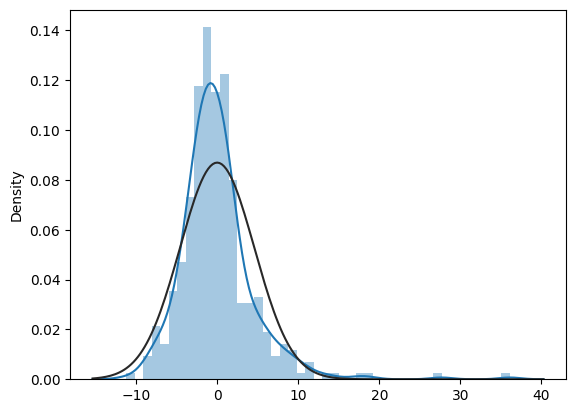

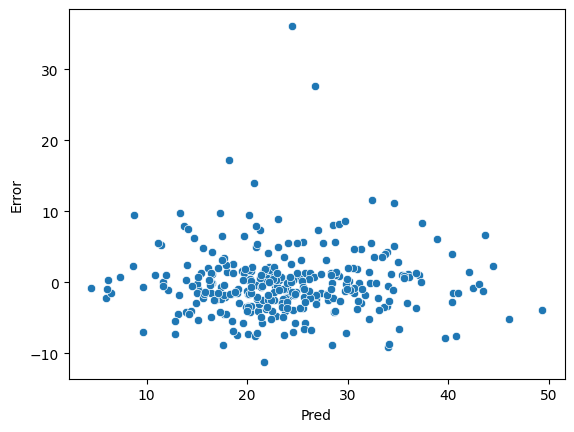

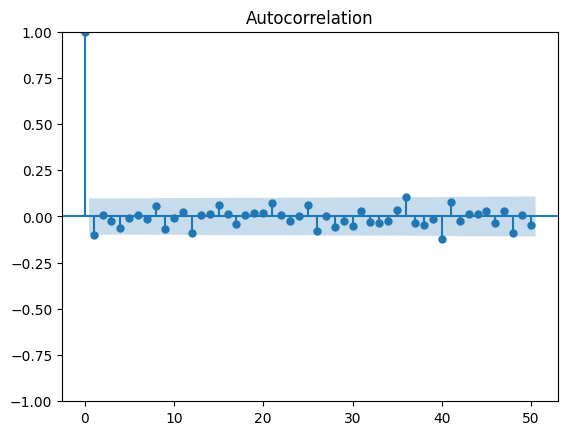

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50)
Test Statistics,0.86,0.73,9.18,50.77
p-value,0.00,0.03,0.51,0.44
Alternative,NaN,two-sided,NaN,NaN


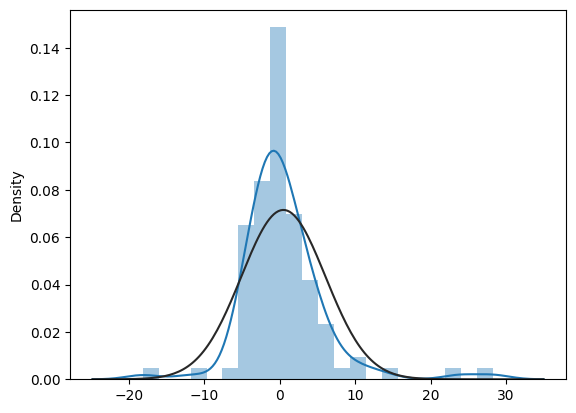

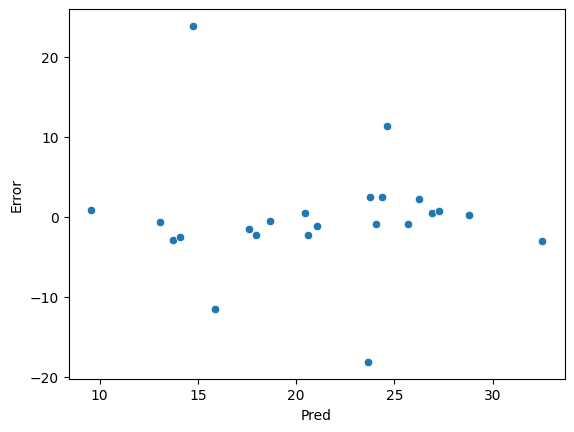

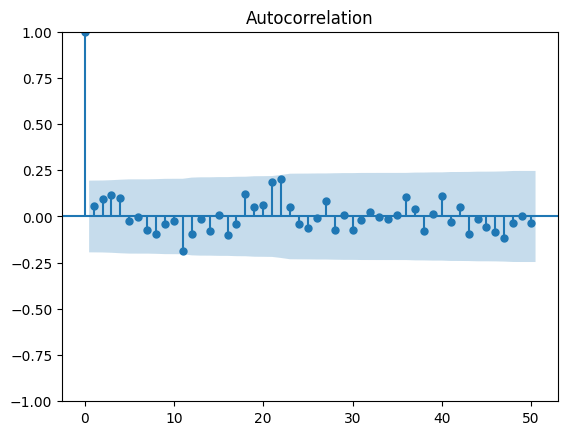

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50)
Test Statistics,0.83,0.13,5.77,41.83
p-value,0.00,0.00,0.83,0.79
Alternative,NaN,two-sided,NaN,NaN


In [14]:
# 에러 분석
Resid_tr = Y_train - Y_trpred.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']

Error_tr = error_analysis(X_train_fes, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr)
Error_te = error_analysis(X_test_fes, Y_tepred, Resid_te, graph_on=True)
display(Error_te)